In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('data/HOLLISTR_1_N101.csv')
df = df[['INTERVALSTARTTIME_GMT', 'MW', 'LMP_TYPE']]
df = df[df['LMP_TYPE'] == 'LMP']
df.drop(columns=['LMP_TYPE'], inplace=True)
df.reset_index(inplace=True, drop=True)
df.columns = ['dt', 'MW']
df['dt'] = pd.to_datetime(df['dt'].str.slice(0, -6).str.replace('T', ' '))
df.set_index('dt', inplace=True)
train, test = df.iloc[:len(df)//2], df.iloc[len(df)//2:]
df

,MW
dt,
2022-03-20 00:00:00,144.25465
2022-03-20 00:05:00,135.43588
2022-03-20 00:10:00,138.42427
2022-03-20 00:15:00,179.78500
2022-03-20 00:20:00,180.75333
...,...
2023-03-19 23:35:00,55.79147
2023-03-19 23:40:00,56.35817
2023-03-19 23:45:00,61.58179


In [4]:
model = ARIMA(train, order=(5, 1, 1))
model = model.fit()

/home/orventro/anaconda3/envs/mgrl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/home/orventro/anaconda3/envs/mgrl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/home/orventro/anaconda3/envs/mgrl/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


In [5]:
model.params

ar.L1        0.817526
ar.L2        0.062194
ar.L3        0.007356
ar.L4        0.042105
ar.L5        0.028030
ma.L1       -0.999025
sigma2    1028.833155
dtype: float64

In [ ]:
model.forecast(10)

2022-09-18 12:00:00     70.519338
2022-09-18 12:05:00     67.300209
2022-09-18 12:10:00     75.680114
2022-09-18 12:15:00     74.115389
2022-09-18 12:20:00     83.765553
2022-09-18 12:25:00     83.764671
2022-09-18 12:30:00     93.725572
2022-09-18 12:35:00     96.819807
2022-09-18 12:40:00    106.725956
2022-09-18 12:45:00    113.318413
Freq: 5T, Name: predicted_mean, dtype: float64

In [ ]:
pred = pd.DataFrame(model.predict(pd.Timestamp(dt.iloc[0])))
day_min = pred.groupby(pred.index.date).min().join(df.groupby(df.index.date).min())
day_min.columns = 'pred', 'true'
day_min

,pred,true
2022-09-18,70.519338,6.33704


In [ ]:
dt = pd.to_datetime(test.reset_index()['dt'])

Timestamp('2022-09-18 12:00:00')

Index([1663502400, 1663502700, 1663503000, 1663503300, 1663503600, 1663503900,
       1663504200, 1663504500, 1663504800, 1663505100,
       ...
       1679267400, 1679267700, 1679268000, 1679268300, 1679268600, 1679268900,
       1679269200, 1679269500, 1679269800, 1679270100],
      dtype='int64', name='dt', length=52560)

In [ ]:
train.to_timestamp()

TypeError: unsupported Type DatetimeIndex

-2.058777404939098


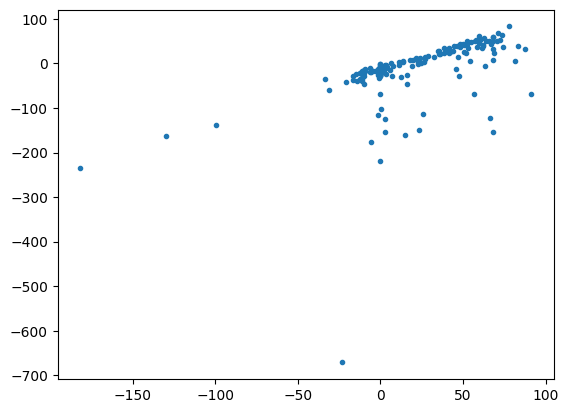

In [ ]:
plt.plot(day_min['true'], day_min['pred'], '.')
print(r2_score(day_min['true'].values, day_min['pred'].values+15))

In [ ]:
r2_score(np.linspace(0, 100, 100), np.linspace(-100, 100, 100))

-2.9405940594059388

In [ ]:
diff = (day_min['true'] - day_min['pred']) ** 2
day_min_dcnt = day_min[diff < np.quantile(diff, 0.9)]
r2_score(day_min_dcnt['true'].values, day_min_dcnt['pred'].values+15)

0.8971578280407344

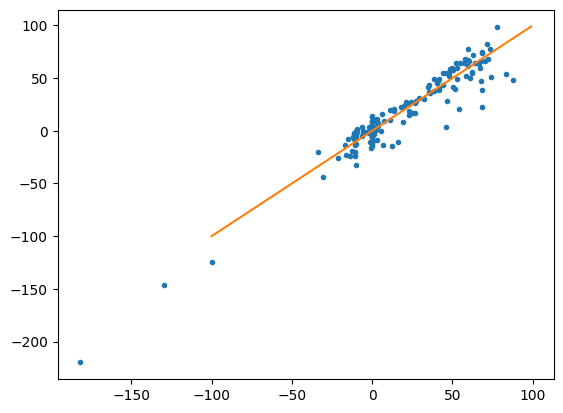

In [ ]:
plt.plot(day_min_dcnt['true'], day_min_dcnt['pred']+15, '.')
plt.plot(np.arange(-100, 100), np.arange(-100, 100))